# Multi-Label Image Classification with TensorFlow 2.0

Multi-label classification problems can be thought of as many independant binary classification problems to solve at the same time.  

In this notebook, we show how to build a machine learning model that predicts the genre of a movie given its poster.  
For each movie poster, the model will assign zero or many labels (Drama, Action, Romance, etc.).  
This is different from traditional multi-class classification problems where each observation ends up having one single label.  

Our workflow will look like this:
1. Data collection
2. Data preparation
3. Create a fast input pipeline in TensorFlow
4. Build up the model
    * Get a transfer learning layer using TensorFlow Hub
    * Stack a multi-label neural network classifier on top
5. Model training and evaluation
6. Understand the role of macro soft-F1 loss
7. Export and save tf.keras models

In [2]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
print("TF version:", tf.__version__)

TF version: 2.6.0


## Data Collection

We will be using the movie posters dataset obtained from Kaggle [Movie Genre from its Poster](https://www.kaggle.com/neha1703/movie-genre-from-its-poster).

You can get a csv file named 'MovieGenre.csv' which groups together information about movies including links to download posters as well as their genres.
These information were collected from [IMDB website](https://www.imdb.com/).

### Read dataset file

In [102]:
movies = pd.read_csv("./data/movie_poster/MovieGenre.csv", encoding="ISO-8859-1")
movies.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


### Clean dataset

In [103]:
# Remove rows having a missing Id, Genre or Poster 
movies.dropna(subset=['imdbId', 'Genre', 'Poster'], inplace=True)
# Remove "Adult" movies
movies.drop(movies[movies['Genre'].str.contains('Adult')].index, inplace=True)
# Show some examples
movies.head(3)
movies.shape

(39254, 6)

### Download images

We prefer downloading multiple images in parallel to save time.  
There is a helper function called `download_parallel` in the `utils` module that does exactly that.

In [13]:
# Define destination folder
destination = './data/movie_poster/images'
# Download in parallel and return the successful subset of the movies dataframe
movies = download_parallel(movies, destination)

Directory './data/movie_poster/images' already exists and will be deleted.
Created new directory './data/movie_poster/images'

Downloading...

Download in parallel mode took 1828 seconds.
Success: 36797
Errors: 2457


> If the number of errors is not 0, it means that some movie posters could not be downloaded.  
These posters are then removed from the dataset and the movies dataframe is filtered to keep only successful downloads.  
The final movies dataframe with all downloaded posters will be saved to csv in the `munge` directory.  
So, next time you run this notebook you do not need to download the images again but just read the movies dataframe from the csv file.

In [111]:
# print("Final number of movie posters to keep:", len(movies))

def delete_unwanted(movies, image_dir):
    ls = os.listdir(image_dir)
    ko_list = [int(i.split('.')[0]) for i in ls]

    # Remove not downloaded posters from the dataframe
    print(f'lenght of kolist is {len(ko_list)}')
    movies = movies[movies['imdbId'].isin(ko_list)]
    print(f'lenght of out is {movies.shape[0]}')
    return movies
    
# Save the final movies dataframe to disk
print(movies['imdbId'].head(3))
movies = delete_unwanted(movies,destination)
munge_dir = "./munge"
if not os.path.exists(munge_dir):
    os.makedirs(munge_dir)
movies.to_csv(os.path.join(munge_dir, "movies.csv"), index=False)
movies.shape


0    114709
1    113497
2    113228
Name: imdbId, dtype: int64
lenght of kolist is 36226
lenght of out is 36797


(36797, 6)

### Start here if the dataset is already downloaded.

In [4]:
movies = pd.read_csv("./munge/movies.csv")
print("Number of movie posters in last download: {}\n".format(len(movies)))
movies.head(3)

Number of movie posters in last download: 36797



,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...


## Data preparation
The following preparation steps aim to create training and validation sets that can be used for machine learning.  
For example, if a movie genre is rare, we will remove it from the target variable.  
The model will not learn how to predict that genre if the data covering it is insufficient.

### Analyze label frequencies
Let's examine which movie genres are the most frequent and which ones are rare.  
The following graph will rank all labels in descending frequency order.

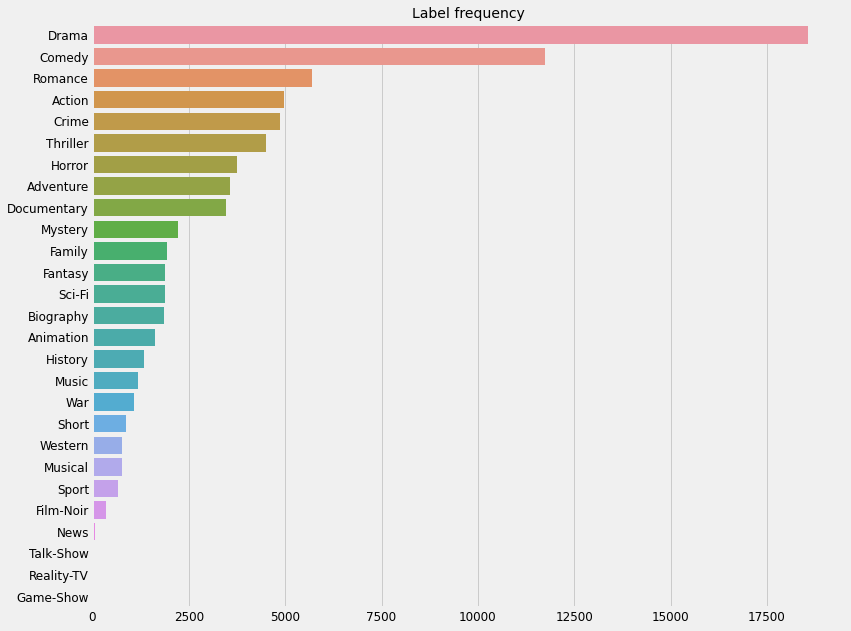

In [5]:
movies['Genre']= movies['Genre'].str.replace("[",'').str.replace(']','').str.replace("'",'').str.replace(',','|')
# Get label frequencies in descending order
label_freq = movies['Genre'].apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Remove infrequent labels
We will consider as a rare label every label that is covered by less than 1000 posters in our dataset.  
We will assume that these labels are very hard to predict due to lack of sufficient data.  
The model that we will train later will not focus on predicting these labels.  
So, we need to make some transformation in the label column (Genre) where we ignore infrequent labels by hiding them.

In [6]:
# Create a list of rare labels
rare = list(label_freq[label_freq<1000].index)
print("We will be ignoring these rare labels:", rare)

We will be ignoring these rare labels: ['Short', 'Western', 'Musical', 'Sport', 'Film-Noir', 'News', 'Talk-Show', 'Reality-TV', 'Game-Show']


In [7]:
# Transform Genre into a list of labels and remove the rare ones
movies['Genre'] = movies['Genre'].apply(lambda s: [l for l in str(s).split('|') if l not in rare])
movies.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,"[Comedy, Family, Romance]",https://images-na.ssl-images-amazon.com/images...


### Train / val split
Splitting the modeling data into training and validation is common in machine learning practice.  
We will be allocating 80% of the images for training and 20% for validation.  
Usually, we keep a final test set to communicate performance results but we will not really need it in this notebook.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(movies['imdbId'], movies['Genre'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  29437
Number of posters for validation:  7360


We need to complete the full path to locate training and test images from the current working directory.


In [9]:
X_train = [os.path.join('./data/movie_poster/images', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('./data/movie_poster/images', str(f)+'.jpg') for f in X_val]
X_train[:3]

['./data/movie_poster/images/54022.jpg',
 './data/movie_poster/images/1583213.jpg',
 './data/movie_poster/images/104802.jpg']

We need the targets to be a list of list of strings in order to fit a binarizer (multi-hot encoding).

In [10]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['Comedy', 'Romance'], ['Drama'], ['Drama', 'Music']]

### Image examples
Let's display some examples of training images.

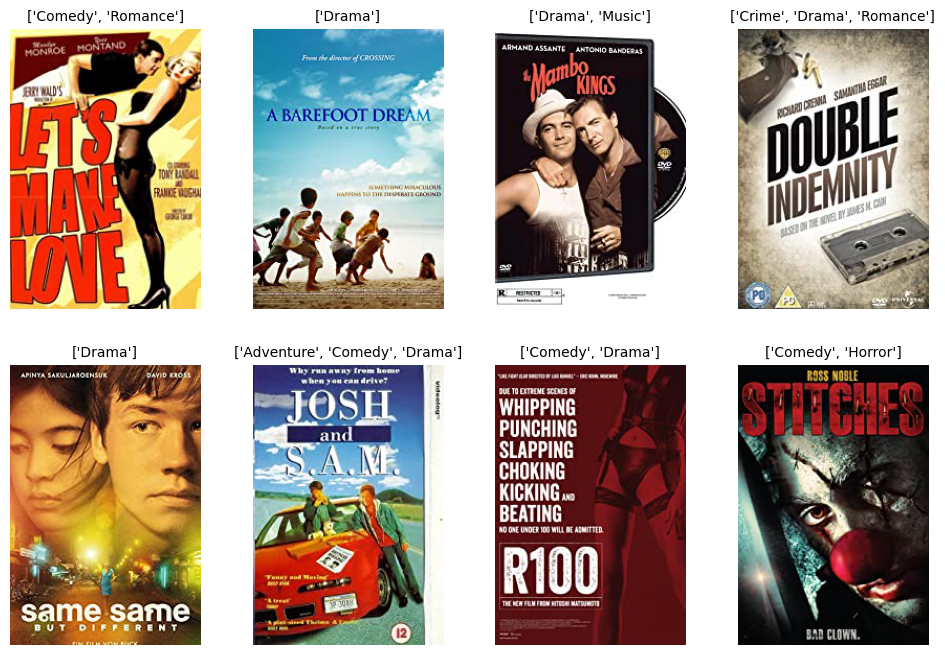

In [11]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

### Label encoding
The original targets are lists of strings that can be easily understood by humans.  
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).  
This is critical for multi-label classification.  

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.  

In [12]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. Action
1. Adventure
2. Animation
3. Biography
4. Comedy
5. Crime
6. Documentary
7. Drama
8. Family
9. Fantasy
10. History
11. Horror
12. Music
13. Mystery
14. Romance
15. Sci-Fi
16. Thriller
17. War


In [13]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

Let's check if everything worked correctly (We should obtain binary targets instead of list of strings).

In [14]:
# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

./data/movie_poster/images/54022.jpg [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
./data/movie_poster/images/1583213.jpg [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
./data/movie_poster/images/104802.jpg [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]


## Fast input pipeline

If you are familiar with [keras.preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) you may know the image data iterators (E.g. [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), [DirectoryIterator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator)).  
These iterators are convenient for multi-class classfication where the image directory contains one subdirectory for each class.  
But, in the case of multi-label classification, having an image directory that respects this structure is not possible because one observation can belong to multiple classes at the same time.

That is where the [tf.data](https://www.tensorflow.org/guide/data) API has the upper hand.

* It is faster.
* It provides fine-grained control.
* It is well integrated with the rest of TensorFlow.


We first need to write some function to parse image files and generate a tensor representing the features and a tensor representing the labels.  
* In this function we can resize the image to adapt to the input expected by the model.  
* We can also normalize the pixel values to be between 0 and 1. This is a common practice that helps speed up the convergence of training.  
If we consider every pixel as a feature, we would like these features to have a similar range so that the gradients don't go out of control and that we only need one global learning rate multiplier.  


In [15]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [16]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

To train a model on our dataset we want the data to be:
* Well shuffled
* Batched
* Batches to be available as soon as possible.

These features can be easily added using the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data) abstraction.

In [17]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

`AUTOTUNE` will adapt the preprocessing and prefetching workload to model training and batch consumption.  
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.  
`AUTOTUNE` will prompt the tf.data runtime to tune the value dynamically at runtime and reduce GPU and CPU idle time.

We can now create a function that generates training and validation datasets for TensorFlow.

In [18]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [19]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)




2021-10-20 02:50:55.844370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [71]:
'/Users/saivivekpeddi/Downloads/Coding/Courses/ECS 171 - TA/multi-label-soft-f1/data/movie_poster/images/34409.jpg' in X_train

True

Each batch will be a pair of arrays (one that holds the features and another one that holds the labels).  
The features array will be of shape (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS).  
The labels array will be of shape (BATCH_SIZE, N_LABELS) where N_LABELS is the maximum number of labels.  
Let's verify the shapes of these arrays by analyzing the first batch:

In [20]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

2021-10-20 02:50:59.890419: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 18)


2021-10-20 02:51:00.503715: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model building (Transfer learning)
Instead of building and training a new model from scratch, we will use a pre-trained model in a process called transfer learning.  
The majority of pre-trained models for vision applications were trained on [ImageNet](http://www.image-net.org/) which is a large image database with more than 14 million images divided into more than 20 thousand categories. The idea behind transfer learning is that these models, because they were trained in a context of large and general classification task, can then be used to address a more specific task by extracting and transfering meaningful features that were previously learned. All we need to do is acquire a pre-trained model and simply add a new classfier on top of it. The new classification head will be trained from scratch so that we repurpose the objective to our multi-label classfication task.

>**Aknowledgement**  
TensorFlow core team did a great job sharing pre-trained models and tutorials on how to use them with `tf.keras` API.  
https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub  
https://www.tensorflow.org/tutorials/images/transfer_learning

[TensorFlow Hub](https://www.tensorflow.org/hub/) is a library that allows to publish and reuse pre-made ML components.  
Using TF.Hub it is simple to retrain the top layer of a pre-trained model to recognize the classes in a new dataset.  
TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

### Download the headless model

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev can be interesting for our dataset.  
The only condition is to insure that the shape of image features in our prepared dataset matches the expected input shape of the model we want to reuse.

First, let's prepare the feature extractor. We will be using a pre-trained [instance of MobileNet V2](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4) with a depth multiplier of 1.0 and an input size of 224x224. MobileNet V2 is actually a large family of neural network architectures that were mainly designed to speed up on-device inference. They come in different sizes depending on the depth multiplier (number of features in hidden convolutional layers) and the size of input images.

In [21]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

The feature extractor accepts images of shape (224, 224, 3) and returns a 1280-length vector for each image.

We should freeze the variables in the feature extractor layer, so that the training only modifies the new classification layers.  
Usually, it is a good practice when working with datasets that are very small compared to the orginal dataset the feature extractor was trained on.

In [22]:
feature_extractor_layer.trainable = False

>Fine tuning the feature extractor is only recommended if the training dataset is large and very similar to the original ImageNet dataset.

### Attach a classification head

Now, we can wrap the feature extractor layer in a `tf.keras.Sequential` model and add new layers on top.

In [23]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 18)                18450     
Total params: 3,588,178
Trainable params: 1,330,194
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.2M parameters in MobileNet are frozen, but there are 1.3K trainable parameters in the dense layers.  
We apply the sigmoid activation function in the final neurons to ouput a probability score for each label apart.  
Every final neuron will act as a seperate binary classifier for one single label, even though the features extracted are common to all final neurons.

Verify the result of running a forward propagation on the first observation of the first batch.  
Normally, we should see a probability score for each genre and that probability scores do not necessarily sum up to 1.  
This is different from using a softmax layer in multi-class classification where the sum of output probability scores is equal to 1. 

In [24]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.635355   0.5713772  0.8178704  0.48814428 0.9173683  0.32735923
  0.6604079  0.7125325  0.22070673 0.36245665 0.294303   0.36508483
  0.31168294 0.6486383  0.3568484  0.24486014 0.2116454  0.6371604 ]]


2021-10-20 02:51:23.431349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model training and evaluation

In the previous steps, we have prepared our dataset and composed a model by attaching a multi-label neural network classifier on top of a pre-trained network (without output). We can now proceed to training our model but we need to define two major functions:
* **A loss function:** We need it to measure the model error (cost) on traning batches.  
It has to be differentiable in order to [backpropagate](https://en.wikipedia.org/wiki/Backpropagation) the error in the neural network and update the weights.
* **An evaluation function:** It should represent the final evaluation metric we really care about.  
Unlike the loss function it has to be more intuitive to understand what the model performance will look like in the real world.

The purpose of this notebook is not only to share a general design for multi-label classfication but also to investigate the advantage of customizing the choice of the loss function to optimize directly for the evaluation metric we care about.

Let's say we need the `F1-score` to evaluate the performance of the model on each label. The [F1-score](https://en.wikipedia.org/wiki/F1_score) is the harmonic mean of `Precision` and `Recall`. And, the computation of Precision and Recall takes into account the number of `True Positives (TP)`, the number of `False Positives (FP)` and the number of `False Negatives (FN)` when considering any specific label.  
https://en.wikipedia.org/wiki/Confusion_matrix

<img src="./img/confusion_matrix.png" width="600">

We compute as many F1-scores as the total number of labels and then average them to get what we call a `Macro F1-score`. It is reasonable to take the average over all labels if they have the same importance in the multi-label classification task.

The problem of the F1-score is that it is not differentiable and so we cannot use it as a loss function to compute gradients and update the weights when training the model. This is because the F1-score needs binary predictions (0/1) to be measured. These binary predictions are obtained by applying a decision theshold on the probability scores generated by the model. For example, we can predict 1 (a movie is about Action) if the probability for Action is above the threshold of 0.5, otherwise we predict 0 (no Action).

Usually we use the `binary cross-entropy loss` which represents the negative log likelihood <font color='grey'>-log(p)</font> of an observation being of a specific class with the model predicting a probability <font color='grey'>p</font> for that class.  Generally this loss works well and is widely used to train classifiers but it does not directly link and align with the F1-score we want to maximize.

What we can do is modify the F1-score to make it differentiable. Instead of computing the number of True Positives, False Positives, False Negatives as discrete integer values, we can compute them as a continuous sum of likelihood values by using probabilities without applying any threshold.  
To better understand this transformation let's see two examples.

**Example 1:** If the target is 1 for a movie being Action and the model prediction for Action is 0.8, it will count as:
* 0.8 x 1 = 0.8 TP (because the target is 1 and the model predicted 1 with 0.8 chance)
* 0.2 x 1 = 0.2 FN (because the target is 1 and the model predicted 0 with 0.2 chance)
* 0.8 x 0 = 0 FP (because the target is 1 not 0, condition negative is not valid)
* 0.2 x 0 = 0 TN (because the target is 1 not 0, condition negative is not valid)

**Example 2:** If the target is 0 for a movie being Action and the model prediction for Action is 0.8, it will count as:
* 0.8 x 0 = 0 TP (because the target is 0 not 1, condition positive is not valid)
* 0.2 x 0 = 0 FN (because the target is 0 not 1, condition positive is not valid)
* 0.8 x 1 = 0.8 FP (because the target is 0 and the model predicted 1 with 0.8 chance)
* 0.2 x 1 = 0.2 TN (because the target is 0 and the model predicted 0 with 0.2 chance)


We will call this version of F1-score a `soft-F1-score`. Below, you can see the code that implements it on a batch of predictions in TensorFlow.  

There are certain things to consider here:
* The cost for each label is actually `1 - soft-F1` for that label. If we want to maximize soft-F1, we should minimize 1 - soft-F1.
* You can replace Precision and Recall in the definition of soft-F1 and get a more direct formula based on terms of TP, FP and FN. The reason you want to do that is because the harmonic mean expression for F1 is undefined when TP = 0, but the translated expression is defined. F1 = 2.TP / (2.TP + FN + FP)
* The total cost in a batch of observations will be the average cost on all labels. We will call it a `macro soft-F1 loss`.
* We have to make sure that the batch size is big enough to see a representative macro soft-F1 loss while training.

In [25]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

Next, we will be training two models with the same architecture but two different loss functions:
* The first one will be trained with the macro soft-F1 loss.    
* The second one will be trained using the binary cross-entropy loss.  

On the other hand, we may consider one single evaluation metric by default for both models: <font color='darkorange'>macro F1-score @ threshold 0.5</font>.

In [26]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

### Train the model using the macro soft-F1 loss

Specify the learning rate and the number of training epochs (number of loops over the whole dataset).

In [27]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

Compile the model to configure the training process.

In [28]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

Now, we pass the training dataset of (features, labels) to fit the model and indicate a seperate dataset for validation.  
The performance on the validation dataset will be measured after each epoch.

In [29]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/30
115/115 [==============================] - 440s 4s/step - loss: 0.8168 - macro_f1: 0.1858 - val_loss: 0.8104 - val_macro_f1: 0.1943
Epoch 2/30
115/115 [==============================] - 444s 4s/step - loss: 0.8042 - macro_f1: 0.2116 - val_loss: 0.7977 - val_macro_f1: 0.2288
Epoch 3/30
115/115 [==============================] - 444s 4s/step - loss: 0.7859 - macro_f1: 0.2504 - val_loss: 0.7777 - val_macro_f1: 0.2623
Epoch 4/30
115/115 [==============================] - 452s 4s/step - loss: 0.7676 - macro_f1: 0.2767 - val_loss: 0.7625 - val_macro_f1: 0.2775
Epoch 5/30
115/115 [==============================] - 440s 4s/step - loss: 0.7535 - macro_f1: 0.2881 - val_loss: 0.7518 - val_macro_f1: 0.2845
Epoch 6/30
115/115 [==============================] - 441s 4s/step - loss: 0.7426 - macro_f1: 0.2953 - val_loss: 0.7436 - val_macro_f1: 0.2888
Epoch 7/30
115/115 [==============================] - 450s 4s/step - loss: 0.7345 - macro_f1: 0.3011 - val_loss: 0.7372 - val_macro_f1: 0.2937

Visualize the learning curves on the training and validation sets when using the macro soft-F1 loss.  
The funtion that plots learning curves was implemented and imported from `utils` module.

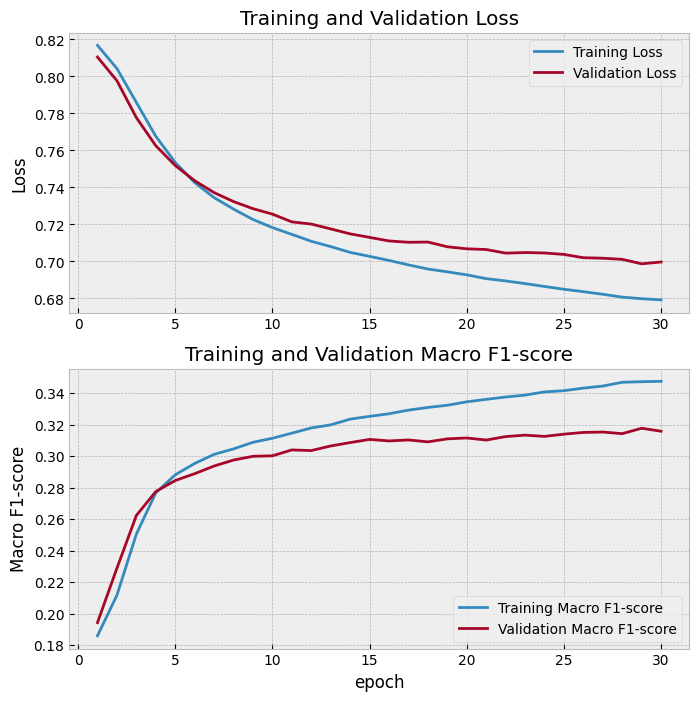

In [30]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

Indicate the performance measured on the validation set.

In [31]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.70
Macro F1-score: 0.32


> You may have noticed here that a decrease in the macro soft-F1 loss to a level near 0.69 is associated with an increase in the macro F1-score to a level near 0.33. These two values almost complement to 1. Remember that the macro soft-F1 loss we defined was actually the macro of 1 - soft-F1 that we needed to minimize. This is a first indicator that the macro soft-F1 loss is directly optimizing for our evaluation metric which is the macro F1-score @ threshold 0.5.

Indicate the performance measured on the validation set.

In [33]:
print("Macro soft-F1 loss: %.2f" %model_bce_val_losses[-1])
print("Macro F1-score: %.2f" %model_bce_val_macro_f1s[-1])

Macro soft-F1 loss: 0.27
Macro F1-score: 0.18


## Role of macro soft-F1 loss

So far, we have trained two neural network models with same architecture.  
The first one was optimizing directly for the macro F1-score, while the second one is more classic and optimized for the binary cross-entropy.  
In both cases, the model trained will generate an independent probability score for each label when predicting the genre of a movie poster.  
To create a final decision system, we need to pick a decision threshold between 0 and 1 for each label 
so as to transform each probability into a binary information. Usually the performance of the system depends on the choice of these decision thresholds.  
So, let's examine how the system behaves on the validation set depending on the level where we set the threshold for each label.  

### Decision threshold

There is a function named `perf_grid` in the `utils` module that helps create the performance grid.  
In the performance grid, thresholds increment from 0 to 1 by a step of 0.01 for each label.  
For each threshold and for each label, we compute different measures (tp, fn, fp, precision, recall, f1-score).

In [37]:
# Get all label names
label_names = mlb.classes_
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(val_ds, y_val_bin, label_names, model)

##  Show predictions

We can try and see what the predictions will look like when using our model on posters of some known movies.  
The following function simplifies the process of preparing poster data, generating the prediction from the model and visualizing it.

In [33]:
def show_prediction(title, movies_df, model):
    
    # Get movie info
    imdbId = movies.loc[movies['Title']==title]['imdbId'].iloc[0]
    genre = movies.loc[movies['Title']==title]['Genre'].iloc[0]
    img_path = os.path.join('./data/movie_poster/images', str(imdbId)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.show()

Loop over some movie titles and show the predicted genre.

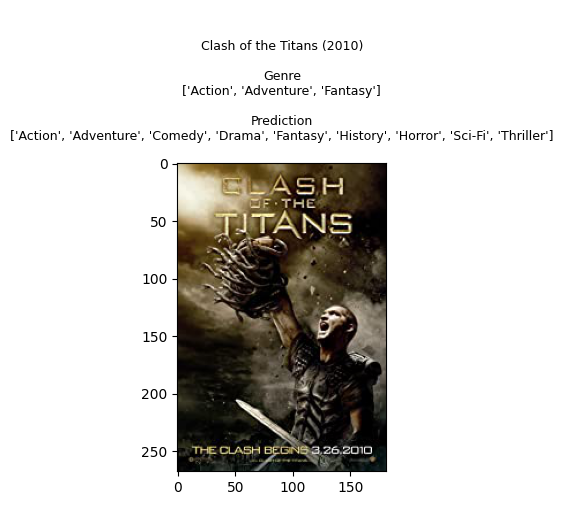

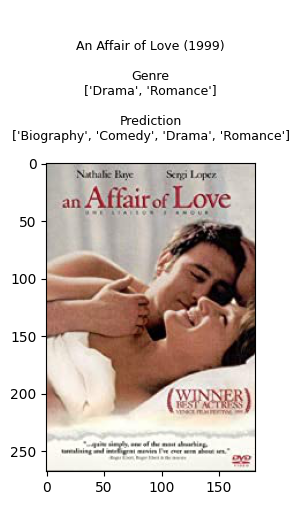

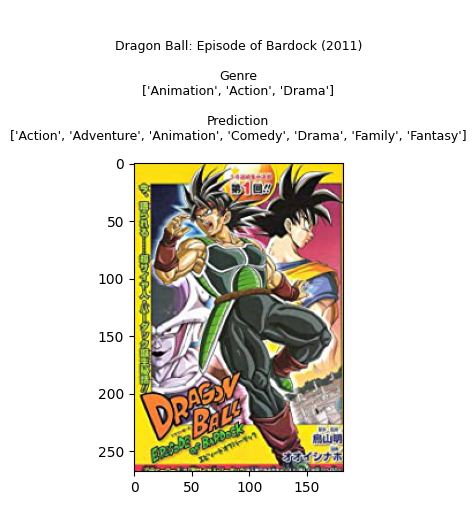

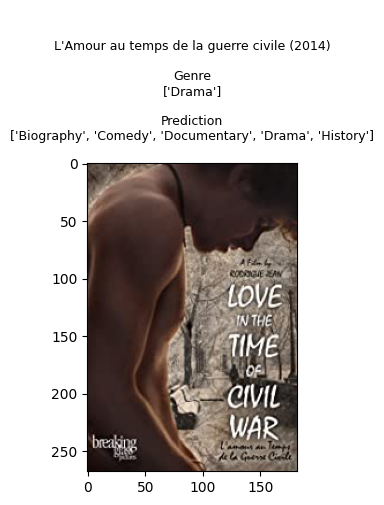

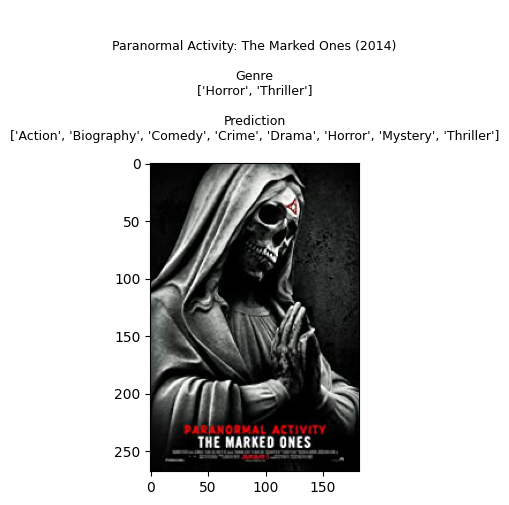

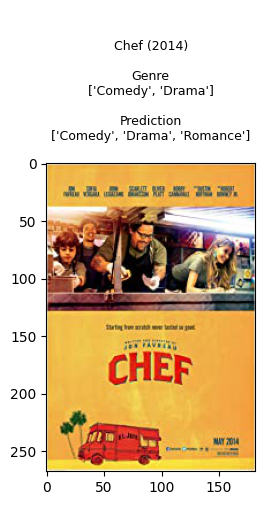

In [38]:
titles = ["Clash of the Titans (2010)",
          "An Affair of Love (1999)",
          "Dragon Ball: Episode of Bardock (2011)",
          "L'Amour au temps de la guerre civile (2014)",
          "Paranormal Activity: The Marked Ones (2014)",
          "Chef (2014)"]

for t in titles:
    show_prediction(t, movies, model)

## Export models

After having trained and evaluated the two models, we can export them as a TensorFlow saved model for future use.

In [49]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/soft-f1_{}".format(t)
tf.keras.models.save_model(model,export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

# export_path_bce = "./models/bce_{}".format(t)
# tf.keras.experimental.export_saved_model(model_bce, export_path_bce)
# print("Model with bce was exported in this path: '{}'".format(export_path_bce))

Model with macro soft-f1 was exported in this path: './models/soft-f1_20211020_144921'


We can later reload a tf.keras model by specifying the path to the export directory containing the .pb file.

In [55]:
# reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

model2 = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer},compile=False)


In [56]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 18)                18450     
Total params: 3,588,178
Trainable params: 1,330,194
Non-trainable params: 2,257,984
_________________________________________________________________


## Summary

* **Multi-label classification**: When the number of possible labels for an observation is greater than one, we should rely on multiple logistic regressions to solve many independant binary classification problems. The advantage  of using neural networks is that we can solve these many problems at the same time inside the same model. Mini-batch learning helps reduce memory complexity while training.

* **Using TensorFlow data API**:  tf.data makes it possible to build fast input pipelines for training and evaluating TensorFlow models. Using the tf.data.Dataset abstraction, we can collect observations as a pair of tensor components representing the image and its labels, preprocess them in parallel and do the necessary shuffling and batching in a very easy manner.

* **Using TensorFlow Hub**:  Transfer learning has never been this simple. TF.Hub provides reusable components from large pre-trained ML models. We could load a MobileNet feature extractor wrapped as keras layer and attach our own fully connected layers on top. The pre-trained model was frozen and only the weights of our classification layers were updated during training.

* **Optimizing directly for macro F1**: By introducing the macro soft-F1 loss, we could train the model to directly increase the metric we care about: the macro F1-score @ threshold 0.5. We could clearly observe the alignment during training and evaluation on successive epochs. When using this loss, we do not have to tune the decision threshold any more. Imagine a multi-label classification system with hundreds of labels, how unstable the system will be if we have to continuously update the optimal threshold for each label. The macro soft-F1 loss comes to the rescue. By using it, we can keep all thresholds fixed at 0.5 and still get an optimal performance from the training process.